<a href="https://colab.research.google.com/github/mobarakol/Lecture_Edinburgh2024/blob/main/PCA_tSNE_Brain_Tumor_Practical_Edinburgh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Dataset
source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
number of training MRIs slices = 5712 <br>
number of testing MRIs slices = 1311 <br>

Download the dataset:

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

Visualize some samples:

train sample size: 5712 test sample size: 1311
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
(5712, 784)


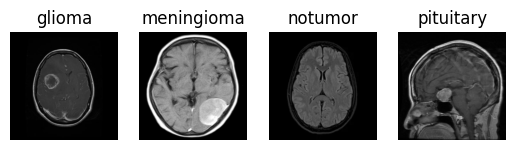

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize,
    ])

train_dataset = datasets.ImageFolder(root='/content/braintumor/Training', transform=my_transform)
test_dataset = datasets.ImageFolder(root='/content/braintumor/Testing', transform=my_transform)

print('train sample size:', len(train_dataset), 'test sample size:', len(test_dataset))
print(train_dataset.class_to_idx)

img_all = []
label_all = []
for data, lab in train_dataset:
    img_all.append(np.array(data)[0,:,:])
    label_all.append(lab)

img_all = np.array(img_all).reshape(len(train_dataset),28*28)
label_all = np.array(label_all)
print(img_all.shape)


class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
newsize = (224, 224)
img_glioma = Image.open('braintumor/Testing/glioma/Te-gl_0014.jpg').resize(newsize)
img_meningioma = Image.open('braintumor/Testing/meningioma/Te-me_0017.jpg').resize(newsize)
img_healthy = Image.open('braintumor/Testing/notumor/Te-noTr_0002.jpg').resize(newsize)
img_pituitary = Image.open('braintumor/Testing/pituitary/Te-piTr_0008.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

PCA

total dimension after PCA reduction: (5712, 2)


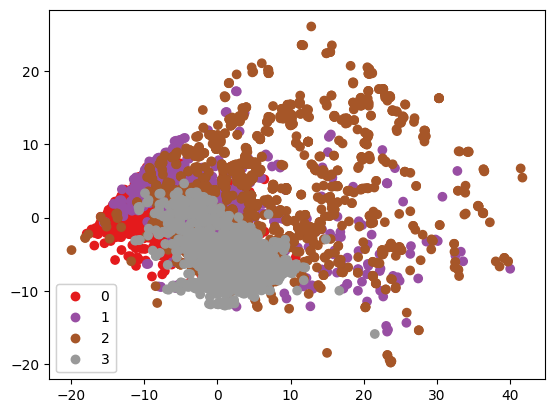

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(img_all)

print('total dimension after PCA reduction:', converted_data.shape)


fig, ax = plt.subplots()
scatter = ax.scatter(converted_data[:, 0], converted_data[:, 1], c=label_all, cmap='Set1')
legend = ax.legend(*scatter.legend_elements(),loc="lower left")
ax.add_artist(legend)
plt.show()
plt.close()

PCA to 3D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px


pca = PCA(3) # we need 3 principal components.
converted_data = pca.fit_transform(img_all)

print('total dimension after PCA reduction:', converted_data.shape)

fig = px.scatter_3d(
    converted_data, x=0, y=1, z=2, title='PCA',width=800, height=800,
    color=label_all, labels={'color': 'digits'}
)
fig.update_traces(marker_size=8)
fig.show()

total dimension after PCA reduction: (5712, 3)


T-SNE

total dimension after t-SNE reduction: (5712, 2)


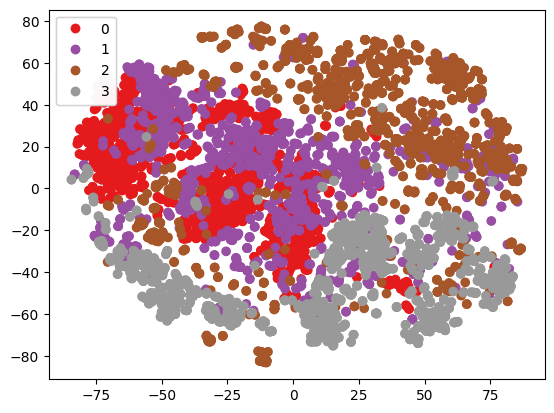

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE().fit_transform(img_all)

print('total dimension after t-SNE reduction:', X_embedded.shape)

# plt.set_cmap('tab10')

fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=label_all, cmap='Set1')

legend = ax.legend(*scatter.legend_elements(),loc="upper left")
ax.add_artist(legend)

plt.show()
plt.close()

T-SNE to 3D

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE

img_all = np.array(img_all).reshape(len(train_dataset),28*28)
label_all = np.array(label_all)

X_embedded = TSNE(n_components=3).fit_transform(img_all)

fig = px.scatter_3d(
    X_embedded, x=0, y=1, z=2, title='t-SNE',width=800, height=800,
    color=label_all, labels={'color': 'tumor'}
)
fig.update_traces(marker_size=8)
fig.show()

#Dimensionality Reduction for Checking Model Robustness and Reliability
Downloading trained weights:

In [3]:
import gdown

!mkdir myweights

#ResNet34
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'myweights/best_model.pth.tar',quiet=True)

#DesnseNet121
url = 'https://drive.google.com/uc?id=1RQHQiF9LrRKbIUSaCOZd8-9paio6DFZ8'
gdown.download(url,'myweights/best_model_densenet8.pth.tar',quiet=True)

'myweights/best_model_densenet8.pth.tar'

ResNet34:

In [4]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
    my_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
        ])

    test_dataset = datasets.ImageFolder(root='/content/braintumor/Testing', transform=my_transform)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = models.resnet34()
    model.fc = nn.Linear(model.fc.in_features, 4)
    model.to(device)
    model.load_state_dict(torch.load('myweights/best_model.pth.tar'))
    model.eval()
    accuracy = test(model, testloader)

    print('Model Accuracy:{:.2f}%'.format(accuracy*100,2))

Model Accuracy:98.78%


#t-SNE to explain the ResNet34 feature representation

Pred shape : (1311, 512)
Target shape : (1311,)


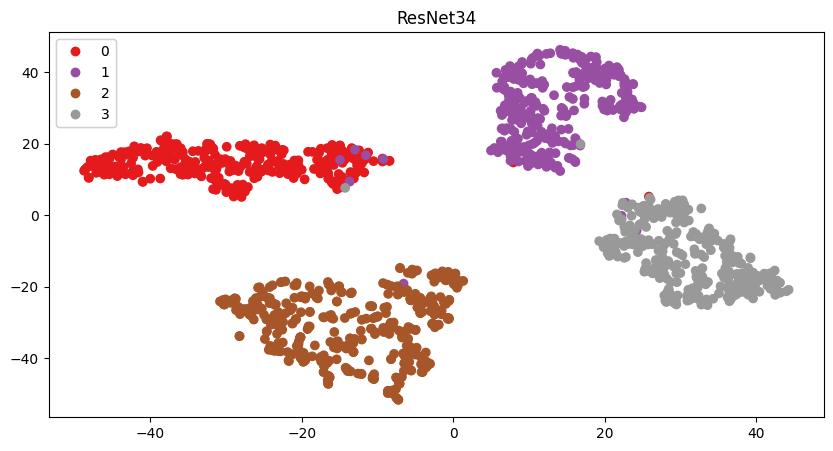

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def get_features(model, testloader):
    model.eval()
    out_targets = []
    out_features = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets
            feature = model(inputs)
            out_features.extend(feature.detach().cpu().numpy())
            out_targets.extend(targets.cpu().numpy())

    return np.array(out_features), np.array(out_targets)

model = models.resnet34()
model.fc = nn.Linear(model.fc.in_features, 4)
model.to(device)
model.load_state_dict(torch.load('myweights/best_model.pth.tar'))
model.fc = nn.Flatten()
model.to(device)

out_features, out_targets = get_features(model, testloader)

print('Pred shape :',out_features.shape)
print('Target shape :',out_targets.shape)

tsne = TSNE(n_components=2, init='pca', random_state=0)
output_array = tsne.fit_transform(out_features)
plt.rcParams['figure.figsize'] = 10,5

fig, ax = plt.subplots()
scatter = ax.scatter(output_array[:,0], output_array[:,1], c=out_targets, cmap='Set1')
legend = ax.legend(*scatter.legend_elements(),loc="upper left")
ax.add_artist(legend)
plt.title('ResNet34')
plt.show()
plt.close()

DesnseNet:

In [6]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
    my_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
        ])

    test_dataset = datasets.ImageFolder(root='/content/braintumor/Testing', transform=my_transform)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = models.densenet121()
    model.classifier = nn.Linear(model.classifier.in_features, 4)
    model.to(device)
    model.load_state_dict(torch.load('myweights/best_model_densenet8.pth.tar'))
    model.eval()
    accuracy = test(model, testloader)

    print('Model Accuracy:{:.2f}%'.format(accuracy*100,2))


Model Accuracy:98.47%


#t-SNE to explain the DesNet121 feature representation

Feature shape : (1311, 1024)
Target shape : (1311,)


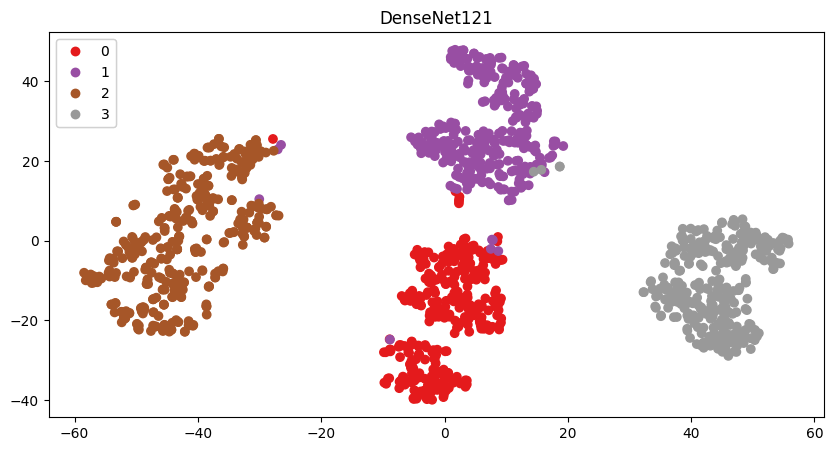

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def get_features(model, testloader):
    model.eval()
    out_targets = []
    out_features = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets
            feature = model(inputs)
            out_features.extend(feature.detach().cpu().numpy())
            out_targets.extend(targets.cpu().numpy())

    return np.array(out_features), np.array(out_targets)

model = models.densenet121()
model.classifier = nn.Linear(model.classifier.in_features, 4)
model.to(device)
model.load_state_dict(torch.load('myweights/best_model_densenet8.pth.tar'))
model.classifier = nn.Flatten()
model.to(device)

out_features, out_targets = get_features(model, testloader)

print('Feature shape :',out_features.shape)
print('Target shape :',out_targets.shape)

tsne = TSNE(n_components=2, init='pca', random_state=0)
output_array = tsne.fit_transform(out_features)
plt.rcParams['figure.figsize'] = 10,5

fig, ax = plt.subplots()
scatter = ax.scatter(output_array[:,0], output_array[:,1], c=out_targets, cmap='Set1')
legend = ax.legend(*scatter.legend_elements(),loc="upper left")
ax.add_artist(legend)
plt.title('DenseNet121')
plt.show()
plt.close()